# 4.- Running the MCMC

Nauyaca uses a Parallel-Tempering sampling algorithm ($\texttt{ptemcee}$; Vousden et al., 2015) to explore the parameter space at different walker temperatures. While walkers at 'hotter' temperatures can explore the parameter space more freely, the walkers at lower temperatures explore in detail small regions with high probability. There is an exchange between walkers at different temperatures, avoiding getting stuck in local high probability regions. The posteriors are drawn from the walkers at temperature 0 (the coldest temperature).

Let's import Nauyaca and other useful libraries for analysis

In [1]:
import nauyaca as nau

import matplotlib.pyplot as plt
import numpy as np

As before, let's load the Planetary System object

In [2]:
PS = nau.PlanetarySystem.load_json('SystemX.json')
print(PS)

--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06

 =========== Planetary System Summary =========== 
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06

System: SystemX
Mstar: 0.9132 Msun |  Rstar: 0.8632 Rsun
Number of planets: 2
Planet information:
------
Planet1: Planet-b
  Boundaries:
    mass: (1, 20.0)  [M_earth]
    period: (5.35, 5.36)  [d]
    ecc: (1e-06, 0.2)   
    inclination: (90, 90)  [deg]
    argument: (0.0, 360)  [deg]
    mean_anomaly: (0.0, 360)  [deg]
    ascending_node: (88.36, 88.36)  [deg]
  TTVs: True
------
Planet2: Planet-c
  Boundaries:
    mass: (1, 50)  [M_earth]
    period: (11.83, 11.84)  [d]
    ecc: (1e-06, 0.2)   
    inclination: (90, 90)  [deg]
    argument: (0.0, 360)  [deg]
    mean_anomaly: (0.0, 360)  [deg]
    ascending_node: (70, 110.0)  [deg]

## 4.1 Initializing walkers

Initial walkers constitute a group of data points in the space of $\mathrm{N_{dim}}$ dimensions that are initially supplied to the MCMC. 

For our current problem, the number of dimensions to explore is:

In [3]:
PS.ndim

11

Thus, each walker will be an array of $\mathrm{N_{dim}}$ dimensions.

Walkers are separated in groups called temperatures. Walkers at hotter temperatures have a greater chance of exploring the space more freely, whilst walkers at lower temperatures explore the space more locally. The maximum temperature in the $temperature\ ladder$ can be specified by the user or adequately chosen by $\texttt{ptemcee}$. The final posterior distributions are taken from the coldest temperature T=0. 

In [4]:
Ntemps = 10       # Number of temperatures
Nwalkers = 50     # Number of walkers per temperature
Tmax = 100        # Maximum temperature. If None, then Parallel-Tempering chose an appropiate maximum temperature

Nauyaca provides 4 build-in functions to easily initialize walkers through the 'initial_walkers' method in the 'utils' module. Additionally, you can provide your own walkers' initial position as long as they are inside the valid boundaries. You can find an example for initializing walkers in the Examples directory.

**IMPORTANT:** Initial walkers should be provided in an array of shape (Ntemps, Nwalkers, Ndim)

In order to visualize how these initial distributions looks like, let's generate these 4 strategies and plot them using the 'Plots' module

In [5]:
nauplot = nau.Plots(PS)

###  4.1.1 Uniform distribution

This is the easier way to initialize walkers, asumming that anything is known about any parameter. For all the planetary parameters, initialize walkers from an uniform distribution along the established boundaries for each planet. Using this option is unnecesary to run optimizers previously. We call it from the 'utils' module:

In [6]:
walkers_uniform = nau.utils.init_walkers(PS, 
                                distribution = "Uniform", 
                                ntemps = Ntemps, 
                                nwalkers = Nwalkers)


--> Selected distribution: Uniform


Text(0.5, 0.98, 'Uniform initial walkers')

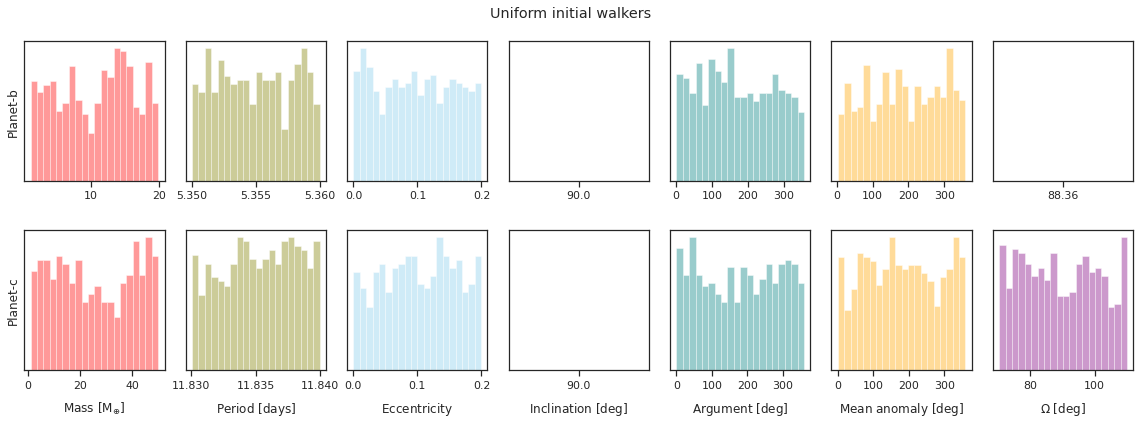

In [11]:
# Show the initial uniform population 
unif = nauplot.hist(chains=walkers_uniform)

unif.subplots_adjust(top=0.9); unif.suptitle("Uniform initial walkers")

**Note:** If there are constant values in the planet's boundaries, then that parameter will be skipped and values will not appear in the initial walkers. Here, panels without information corresponds to planet parameters that remain as fixed. In this case, the constant parameter(s) and the value(s) correspond to:

In [12]:
for constant in PS.constant_params.keys():
    param = PS.params_names_all.split()[constant]
    value = PS.constant_params[constant]
    print(f"{param}: {value}")

inclination1: 90.0
ascending_node1: 88.36
inclination2: 90.0


### 4.1.2 Gaussian distribution

In order to use this function, we need to provide the information comming from the optimizers saved in the **_cube.opt** file (done in tutorial 3). Let's load the results from the optimizers that we got in the previous tutorial by using the numpy function .genfromtxt():

In [14]:
RESULTS_opt = np.genfromtxt(f'{PS.system_name}_cube.opt')

Provide the results directly from the optimizers (through opt_data argument) and construct a gaussian with the mean and standard deviation of the solutions along each dimension. Argument 'fbest' selects a fraction of the best solutions and discard the rest. For example, fbest=.1 takes the best 10% of the solutions, according to their $\chi^2$

In [15]:
walkers_gaussian = nau.utils.init_walkers(PS, 
                                   distribution = "Gaussian",
                                   opt_data = RESULTS_opt, 
                                   fbest = 0.15,
                                   ntemps = Ntemps, 
                                   nwalkers = Nwalkers) 


--> Selected distribution: Gaussian
    15 of 100 solutions taken


**Note:** the walkers_gaussian variable contains the walkers information normalized between 0 and 1. Try printing that variable to corroborate. This normalization is done over each parameter range: 0 for the lower physical bound and 1 for the upper one. 

However, we can visualize the -physical- values by passing that variable to the Plots module through the -chains- kwarg:

Text(0.5, 0.98, 'Gaussian initial walkers')

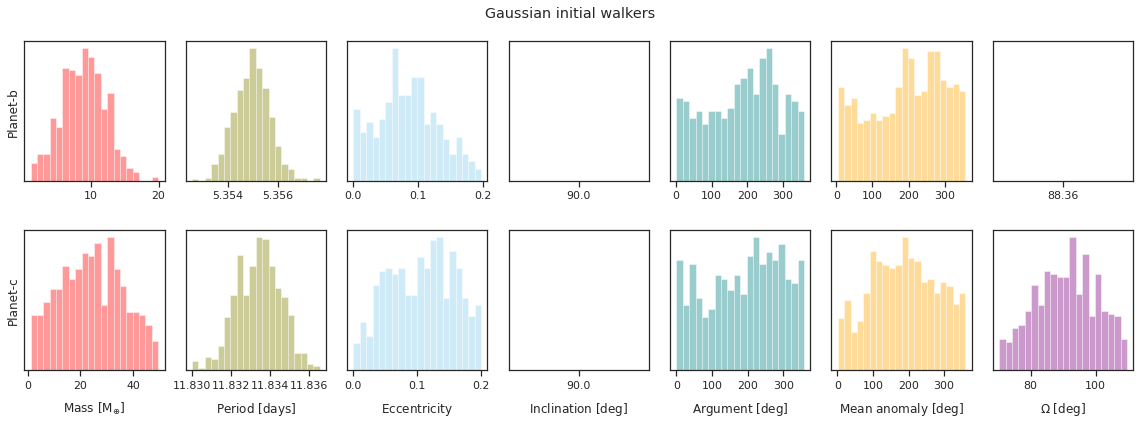

In [16]:
gauss = nauplot.hist(chains=walkers_gaussian)

gauss.subplots_adjust(top=0.9); gauss.suptitle("Gaussian initial walkers")

These will be the initial distribution of walkers drawn from gaussian distributions, coming from the information of the best optimizer solutions.

### 4.1.3 Picked distribution

Using this strategy, optimizer solutions will be randomly selected and walkers will be spawn in "tight gaussian balls" around these solutions. This is repeated for all the temperatures until Ntemps and Nwalkers are reached.

In opt_data, pass RESULTS_opt array obtained from the '_cube.opt' file. As before, fbest selects a fraction of the best solutions and discard the rest. 

In [17]:
walkers_picked = nau.utils.init_walkers(PS, 
                                 distribution = "Picked", 
                                 opt_data = RESULTS_opt, 
                                 fbest = .15,
                                 ntemps = Ntemps, 
                                 nwalkers = Nwalkers)


--> Selected distribution: Picked
    15 of 100 solutions taken


Text(0.5, 0.98, 'Randomly picked initial walkers')

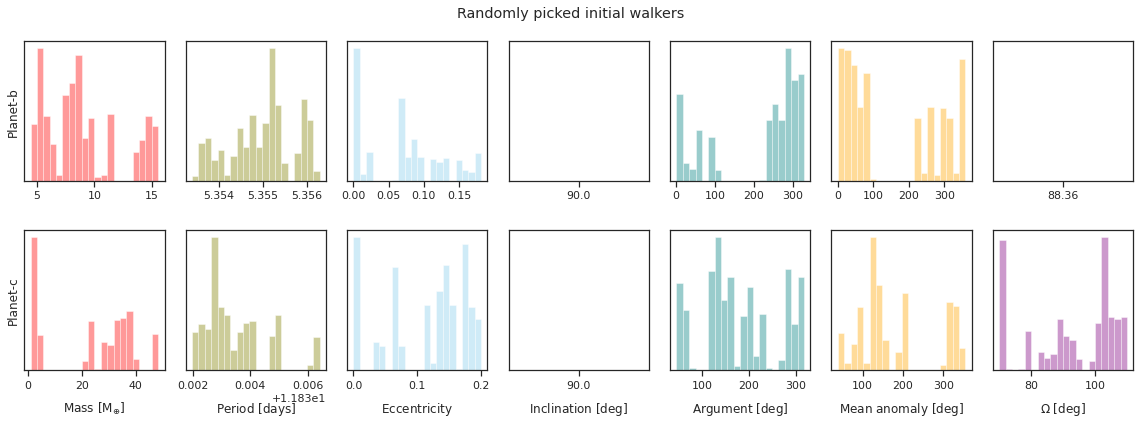

In [21]:
pick = nauplot.hist(chains=walkers_picked)

pick.subplots_adjust(top=0.9); pick.suptitle("Randomly picked initial walkers")

As can be seen, this strategy initialize walkers in specific regions of the space motivated by the discrete optimizer solutions.

### 4.1.4 Ladder distribution

This method separate the solutions from optimizers in chunks corresponding to the number of temperatures. Then, each temperature draw their own walkers by following the rule:
First temperature draw walkers from the first chunk (which includes the solution with the topmost solution). Second temperature draw walkers from first and second chunks. Third temperature draw walkers from first, second and third chunks. The same rule follows for the rest of the temperatures.

In opt_data, pass RESULTS_opt (from file). fbest selects a fraction of the best solutions and discard the rest. 

In [22]:
walkers_ladder = nau.utils.init_walkers(PS, 
                                distribution = "Ladder",
                                opt_data = RESULTS_opt, 
                                fbest = 0.15,
                                ntemps = Ntemps, 
                                nwalkers = Nwalkers)  


--> Selected distribution: Ladder
    15 of 100 solutions taken


Text(0.5, 0.98, 'Ladder strategy')

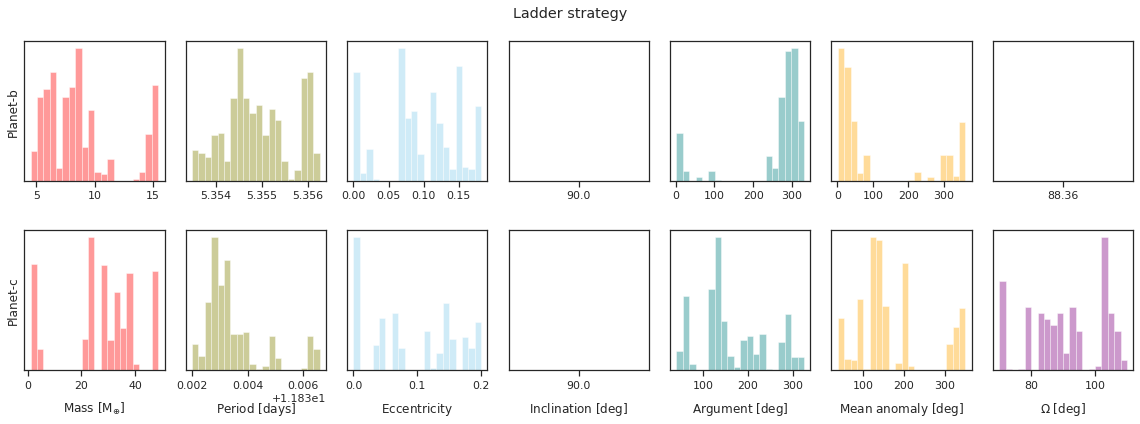

In [23]:
ladd = nauplot.hist(chains=walkers_ladder)

ladd.subplots_adjust(top=0.9); ladd.suptitle("Ladder strategy")

A detailed explanation of these strategies to initialize walkers can be seen at Canul el al. (2021)

## 4.2 Running the MCMC

By default, Nauyaca uses an uninformative constant prior for all the planetary parameters inside our defined boundaries.  Proposals outside these boundaries will be discarded. You can find an example of how to set your own prior in the Examples directory .

Let's define the main parameters to run the MCMC. We will run the MCMC along a fixed number of iterations saving the current status of the chains at a predefined number of steps. For the purposes of this tutorial, we won't reach the convergence and stationarity of the chains, since more iterations will be needed. Although, it's a good way of getting into the MCMC usage.


In [28]:
Itmax = 10000      # Maximum number of steps
Intra_steps = 100  # Run the mcmc saving each 100 steps

Let's run the MCMC using the initial walkers from the Ladder distribution generated above. Also provide the necessary keyword arguments. Depending on the computation facilities, it can take a pair of minutes to complete. 

In [29]:
nauMCMC = nau.MCMC(
            PS,                             # Planetary System object
            p0 = walkers_ladder,            # Initial population of walkers 
            tmax = Tmax,                    # Maximum temperature
            itmax = Itmax,                  # Maximum nomber of iterations (steps)
            intra_steps = Intra_steps,      # Save data each this number of steps
            cores = 7,                      # Number of cores to run in parallel
            )

In [30]:
RESULTS_mcmc = nauMCMC.run()


 =========== PARALLEL-TEMPERING MCMC ===========

--> Starting date:  2021-07-13 13:58
--> Reference epoch of the solutions:  0.0  [JD]
--> Results will be saved at:  ./SystemX.hdf5
--> MCMC parameters:
      -ntemps: 10
      -nwalkers: 50
      -itmax: 10000
      -intra_steps: 100

--------- Iteration:  100
 Mean tau Temp 0: 0.753
 Accepted swap fraction in Temp 0:  0.056
 Mean acceptance fraction Temp 0:  0.086
 Mean log-likelihood:  -499.098
 Mean log-posterior:   -499.098
 Current log-posterior dispersion:  449.197
 Current MAP:  (0, 43) 43.878
 Saving time: 0.01080 sec
 Elapsed time:  0.1869 min
--------- Iteration:  200
 Mean tau Temp 0: 1.488
 Accepted swap fraction in Temp 0:  0.036
 Mean acceptance fraction Temp 0:  0.081
 Mean log-likelihood:  171.014
 Mean log-posterior:   171.014
 Current log-posterior dispersion:  128.732
 Current MAP:  (0, 17) 299.913
 Saving time: 0.00987 sec
 Elapsed time:  0.3832 min
--------- Iteration:  300
 Mean tau Temp 0: 2.223
 Accepted swap f

--------- Iteration:  2600
 Mean tau Temp 0: 17.245
 Accepted swap fraction in Temp 0:  0.043
 Mean acceptance fraction Temp 0:  0.039
 Mean log-likelihood:  315.937
 Mean log-posterior:   315.937
 Current log-posterior dispersion:  6.515
 Current MAP:  (0, 31) 329.194
 Saving time: 0.01123 sec
 Elapsed time:  6.5379 min
--------- Iteration:  2700
 Mean tau Temp 0: 17.789
 Accepted swap fraction in Temp 0:  0.044
 Mean acceptance fraction Temp 0:  0.038
 Mean log-likelihood:  315.556
 Mean log-posterior:   315.556
 Current log-posterior dispersion:  7.705
 Current MAP:  (0, 30) 331.682
 Saving time: 0.01422 sec
 Elapsed time:  6.8087 min
--------- Iteration:  2800
 Mean tau Temp 0: 18.322
 Accepted swap fraction in Temp 0:  0.044
 Mean acceptance fraction Temp 0:  0.038
 Mean log-likelihood:  317.234
 Mean log-posterior:   317.234
 Current log-posterior dispersion:  7.028
 Current MAP:  (0, 31) 333.296
 Saving time: 0.01587 sec
 Elapsed time:  7.0797 min
--------- Iteration:  2900
 Mea

--------- Iteration:  5200
 Mean tau Temp 0: 25.465
 Accepted swap fraction in Temp 0:  0.045
 Mean acceptance fraction Temp 0:  0.029
 Mean log-likelihood:  328.417
 Mean log-posterior:   328.417
 Current log-posterior dispersion:  4.953
 Current MAP:  (0, 13) 336.595
 Saving time: 0.01518 sec
 Elapsed time:  13.3877 min
--------- Iteration:  5300
 Mean tau Temp 0: 25.389
 Accepted swap fraction in Temp 0:  0.044
 Mean acceptance fraction Temp 0:  0.029
 Mean log-likelihood:  328.086
 Mean log-posterior:   328.086
 Current log-posterior dispersion:  5.177
 Current MAP:  (0, 2) 337.589
 Saving time: 0.01554 sec
 Elapsed time:  13.6568 min
--------- Iteration:  5400
 Mean tau Temp 0: 25.285
 Accepted swap fraction in Temp 0:  0.044
 Mean acceptance fraction Temp 0:  0.029
 Mean log-likelihood:  328.866
 Mean log-posterior:   328.866
 Current log-posterior dispersion:  4.457
 Current MAP:  (0, 13) 336.449
 Saving time: 0.01182 sec
 Elapsed time:  13.9119 min
--------- Iteration:  5500
 M

--------- Iteration:  7800
 Mean tau Temp 0: 16.256
 Accepted swap fraction in Temp 0:  0.045
 Mean acceptance fraction Temp 0:  0.026
 Mean log-likelihood:  331.725
 Mean log-posterior:   331.725
 Current log-posterior dispersion:  4.187
 Current MAP:  (0, 17) 338.735
 Saving time: 0.01556 sec
 Elapsed time:  20.1565 min
--------- Iteration:  7900
 Mean tau Temp 0: 15.682
 Accepted swap fraction in Temp 0:  0.045
 Mean acceptance fraction Temp 0:  0.026
 Mean log-likelihood:  331.42
 Mean log-posterior:   331.42
 Current log-posterior dispersion:  4.479
 Current MAP:  (0, 47) 339.802
 Saving time: 0.01653 sec
 Elapsed time:  20.4299 min
--------- Iteration:  8000
 Mean tau Temp 0: 15.099
 Accepted swap fraction in Temp 0:  0.046
 Mean acceptance fraction Temp 0:  0.026
 Mean log-likelihood:  331.098
 Mean log-posterior:   331.098
 Current log-posterior dispersion:  5.139
 Current MAP:  (0, 47) 339.61
 Saving time: 0.01724 sec
 Elapsed time:  20.6964 min
--------- Iteration:  8100
 Mea

After the mcmc run ends, it returns the sampler object from $\texttt{ptemcee}$, with the following attributes:

In [31]:
RESULTS_mcmc.__dict__.keys()

dict_keys(['_random', '_likeprior', 'a', 'nwalkers', 'dim', 'adaptation_time', 'adaptation_lag', '_betas', 'pool', '_chain', '_logposterior', '_loglikelihood', '_beta_history', '_time', '_p0', '_logposterior0', '_loglikelihood0', 'nswap', 'nswap_accepted', 'nprop', 'nprop_accepted'])

Okey, at this point there are two files that have been saved with the following extesions:

* **.hdf5:** It contains the main results from the MCMC run. It will be useful for posterior analysis. It also can be provided to the Plots module to plot default figures from Nauyaca. This file is portable and is useful to restart an MCMC in other time or in another computer. 


* **.best:** It is a file containing the best solution (normalized) of each saved iteration. It correspond to the solution with the Maximum a posteriori 'MAP' indicated in the outputs. It is useful to know the best fit to the TTVs.


## 4.3 Results


For the following analysis, let's make a burnin of the first 25% of the chains. Also remember that results are taken from temperature 0.

In [32]:
burn = 0.25  # Fractional lenght of the initial chains to be discarded

### 4.3.1 MCMC Summary

An easy way to summarize the current MCMC run is through the mcmc_summary method in utils, passing the name of the .hdf5 file.

In [33]:
posteriors = nau.utils.mcmc_summary(PS, 
                                    hdf5_file=f'{nauMCMC.hdf5_filename}', 
                                    burnin=burn, 
                                    get_posteriors=True) # useful to get posterior as arrays

--> Planetary System:  SystemX
    Stellar mass:  0.9132
    Stellar radius:  0.8632
    Number of planets:  2
--> Planets:
       Planet 1: Planet-b
       Planet 2: Planet-c
    
--------------------------
--> MCMC parameters
    Ntemps:  10
    Nwalkers per temperature:  50
    Number of iterations:  10000
    Thining:  100
    Burnin:  0.25
    Chain shape:  (50, 76, 11)
--------------------------
      RESULTS             
--> Results in File:   ./SystemX.hdf5
--> Reference epoch of the solutions:  0  [JD]
--> Best solution in MCMC
      Logl:  343.36501
               mass period ecc inclination argument mean_anomaly ascending_node
      Planet 1: 7.2029   5.3545   0.1161   90.0   287.9127   27.0739   88.36
      Planet 2: 36.5331   11.8334   0.0314   90.0   221.0051   47.331   86.1276
--------------------------
--> MCMC medians and 1-sigma errors
             mass1      7.22 ^{+0.437}_{-0.419}
           period1      5.3546 ^{+5.4e-05}_{-4.5e-05} 
              ecc1      0.121 ^

That function prints a summary of the MCMC run where we can see the best solution found along the entire run and the medians of the posteriors with 1-$\sigma$ erros, corresponding to percentiles 16 and 84. Furthermore, it returns a dictionary with the flatten chains of each planetary parameter:

In [34]:
posteriors

{'mass1': array([7.13330947, 7.00373335, 6.65046057, ..., 6.81819862, 6.97040558,
        6.82334631]),
 'period1': array([5.35470847, 5.35463769, 5.35468235, ..., 5.35452628, 5.35460457,
        5.35462425]),
 'ecc1': array([0.09182069, 0.12254941, 0.12618221, ..., 0.12406842, 0.12319315,
        0.12109656]),
 'argument1': array([302.58649684, 290.11052086, 290.69479022, ..., 288.9226803 ,
        289.53788923, 290.99495632]),
 'mean_anomaly1': array([10.85068266, 24.03087636, 23.12598378, ..., 25.47729371,
        24.73245682, 23.01480094]),
 'mass2': array([38.75569277, 31.30857633, 29.24887303, ..., 35.10668827,
        33.05087373, 33.48613432]),
 'period2': array([11.83307643, 11.83322454, 11.83312525, ..., 11.83320776,
        11.83326468, 11.83317573]),
 'ecc2': array([0.0535195 , 0.02756884, 0.02679711, ..., 0.0213696 , 0.02730436,
        0.02338088]),
 'argument2': array([104.055805  , 268.08518575, 267.08184967, ..., 249.67715983,
        245.72459221, 256.09218753]),
 'me

Now, it's easier to analyze individual parameters. 

Let's plot for example, the posterior of the 'mass1' and calculate the mean:

Mean: 7.23324541297261


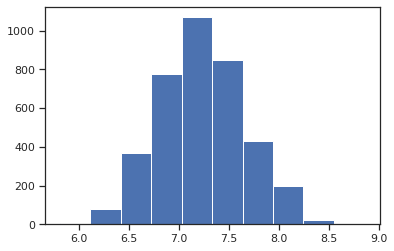

In [35]:
param = 'mass1'
plt.hist(posteriors[param]);

mean = np.mean(posteriors[param])
print(f"Mean: {mean}")

### 4.3.2 The hdf5 file

All the results saved in the .hdf5 file can be accessed through the method 'get_mcmc_results'. First, let's print which keys are available by passing the hdf5 file and setting which_keys to True.

In [36]:
nau.utils.get_mcmc_results(f'{nauMCMC.hdf5_filename}', which_keys=True)

Available keywords: 
 ['ACC_FRAC0', 'AUTOCORR', 'BESTSOLS', 'BETAS', 'BOUNDS', 'BOUNDSP', 'CHAINS', 'COL_NAMES', 'CORES', 'INDEX', 'INTRA_STEPS', 'ITER_LAST', 'ITMAX', 'MAP', 'MEANLOGPOST', 'MSTAR', 'NAME', 'NDIM', 'NPLA', 'NTEMPS', 'NWALKERS', 'REF_EPOCH', 'RSTAR', 'p0']


* These keys mean:

'CHAINS': mcmc chains of shape (temperatures, walkers, steps, dimensions). Use temperature 0 for posterior statistics.

'AUTOCORR': averaged autocorrelation time of temperature 0.

'BETAS': inverse temperatures ladder.

'ACC_FRAC0': accepted temperature swap fractions for each temperature.

'INDEX': the index of the last iteration.

'ITER_LAST': the number of the last iteration, INDEX+1.

'BESTSOLS' the best solution at each saved iteration.

'MAP': the maximum a posteriori estimation at current iteration (corresponding to BESTSOLS).

'MEANLOGPOST': the averaged posterior probability of all the chains at the current iteration.

'p0': Initial population of walkers.

'BOUNDS': the physical flattened planetary boundaries.

'BOUNDSP': the parameterized physical flattened planetary boundaries.

'NDIM': number of dimensions.

'NTEMPS': number of temperatures.

'NWALKERS': number of walkers (per temperature).

'CORES': number of cores used to run in parallel.

'ITMAX': maximum number of mcmc iterations.

'INTRA_STEPS': a number of steps to save the current state of the chains (the thinning factor).

'REF_EPOCH': the reference epoch of the solutions. It is the same as PSystem.t0

'COL_NAMES': the column names corresponding to the dimensions stored in CHAINS.

'NPLA': number of planets.

'MSTAR': stellar mass.

'RSTAR': stellar radius.

These keys correspond to the main features of the MCMC saved in the .hdf5 file. 


Now, let's use the same function as before to extract ALL the results in the hdf5 file, which will return in a dictionary:

In [37]:
results_hdf5 =  nau.utils.get_mcmc_results(f'{nauMCMC.hdf5_filename}')
results_hdf5

{'ACC_FRAC0': array([[0.0562    , 0.0738    , 0.1115    , 0.1363    , 0.1548    ,
         0.1569    , 0.1363    , 0.1114    , 0.0736    , 0.0518    ],
        [0.0361    , 0.043     , 0.06435   , 0.08155   , 0.0928    ,
         0.09655   , 0.0877    , 0.07155   , 0.04675   , 0.034     ],
        [0.02466667, 0.02986667, 0.04593333, 0.0593    , 0.06716667,
         0.06983333, 0.065     , 0.05293333, 0.03413333, 0.02526667],
        [0.0185    , 0.022575  , 0.035375  , 0.0469    , 0.053175  ,
         0.05505   , 0.052125  , 0.043625  , 0.028875  , 0.0213    ],
        [0.01496   , 0.01818   , 0.02916   , 0.03878   , 0.04328   ,
         0.04546   , 0.044     , 0.037     , 0.0249    , 0.0188    ],
        [0.01246667, 0.01523333, 0.02448333, 0.03261667, 0.03666667,
         0.03856667, 0.0372    , 0.03145   , 0.02146667, 0.01636667],
        [0.01068571, 0.01334286, 0.02128571, 0.02811429, 0.03172857,
         0.03348571, 0.0323    , 0.02734286, 0.01867143, 0.01408571],
        [0.009

If you want to get specific results from the hdf5 file (for example if you are interested in the chains only), pass a list with the keyword names through the -keywords- argument, for example: 

    mychains = nau.utils.get_mcmc_results(f'{nauMCMC.hdf5_filename}', keywords=['CHAINS'])

It is helpful to save memory when not all the results are momentarily needed. Otherwise, all the results will be returned.

Not all the attributes in RESULTS_mcmc are stored in the .hdf5 file (ie., in the results_hdf5 variable) but just those necessary to analize the MCMC performance and many properties of the planetary system. 

Let's access, for example, to the mean autocorrelation of the chains at temperature 0:

In [38]:
results_hdf5['AUTOCORR']

array([ 0.75252525,  1.48782032,  2.22341072,  2.95579815,  3.6840989 ,
        4.40767213,  5.12597899,  5.83883631,  6.54280866,  7.23857651,
        7.92670283,  8.60583551,  9.27816425,  9.94442257, 10.60055613,
       11.25000322, 11.89160706, 12.52336748, 13.14630099, 13.7627454 ,
       14.36670605, 14.95915636, 15.54649276, 16.12404995, 16.68935176,
       17.24517958, 17.78893708, 18.32226592, 18.84187675, 19.3488846 ,
       19.84175108, 20.32103347, 20.78512695, 21.23140797, 21.66114099,
       22.0763468 , 22.47192887, 22.84942747, 23.20960518, 23.54573795,
       23.85553094, 24.15018254, 24.41844651, 24.66292603, 24.87858909,
       25.0695137 , 25.23285412, 25.36222116, 25.46107988, 25.52735859,
       25.51246258, 25.4645102 , 25.38931224, 25.28523664, 25.1530266 ,
       24.99874517, 24.82066084, 24.61881486, 24.38994399, 24.13736872,
       23.85744162, 23.55684499, 23.23538962, 22.89290479, 22.52891183,
       22.1414696 , 21.74063015, 21.31519117, 20.87114187, 20.41

## 4.4 Visualization

An easy way of looking into the results is generating descriptive figures using the 'Plots' module. 


In [39]:
# Instantiate the Plots module, and specify the burnin for the results

nauplot = nau.Plots(PS, hdf5_file=f'{nauMCMC.hdf5_filename}', burnin=burn)

**MCMC performance**

We can take a look into the MCMC performance 

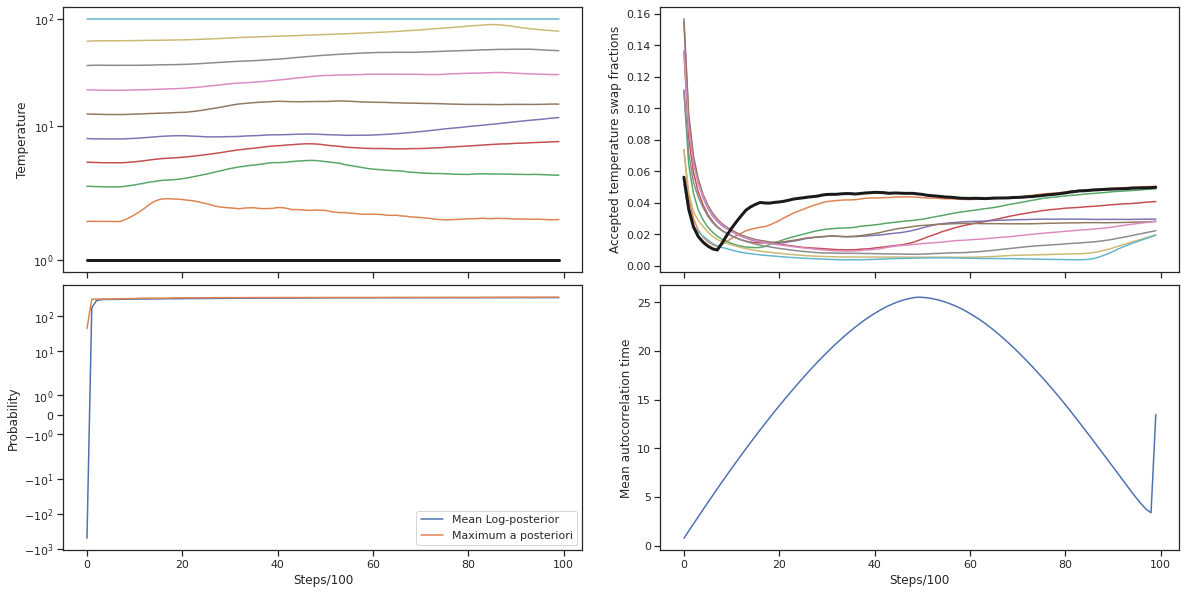

In [40]:
nauplot.monitor();

It shows the movement of the adaptive temperatures, the swap between walkers of different temperatures, the Mean log posterior and the Maximum a posteriori, and the mean autocorrelation time. Note that these steps are normalized by the intra_steps variable defined in nau.MCMC().

**Histograms**

Take a look into the posterior distributions, and set as titles the median and errors within $1-\sigma$

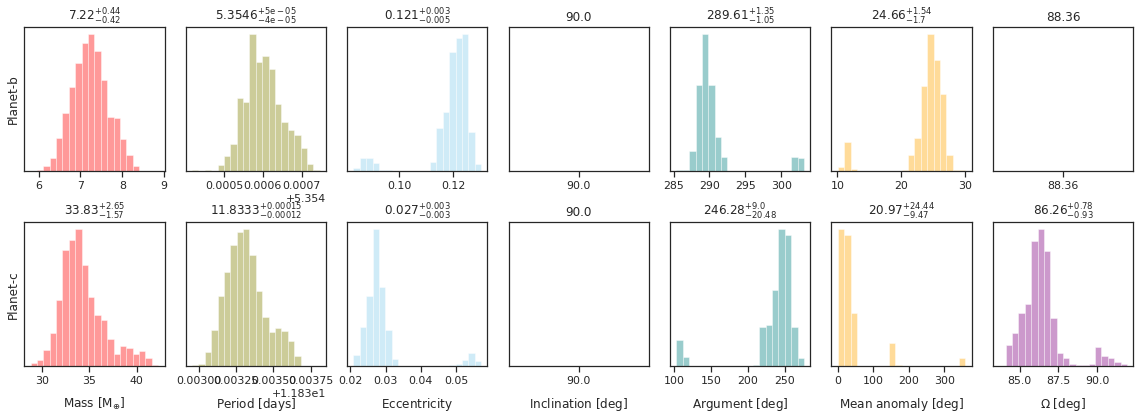

In [41]:
nauplot.hist(titles=True);

**Trace plot**

If you are interested in visualizing the chains movement, use the  'trace_plot' method:

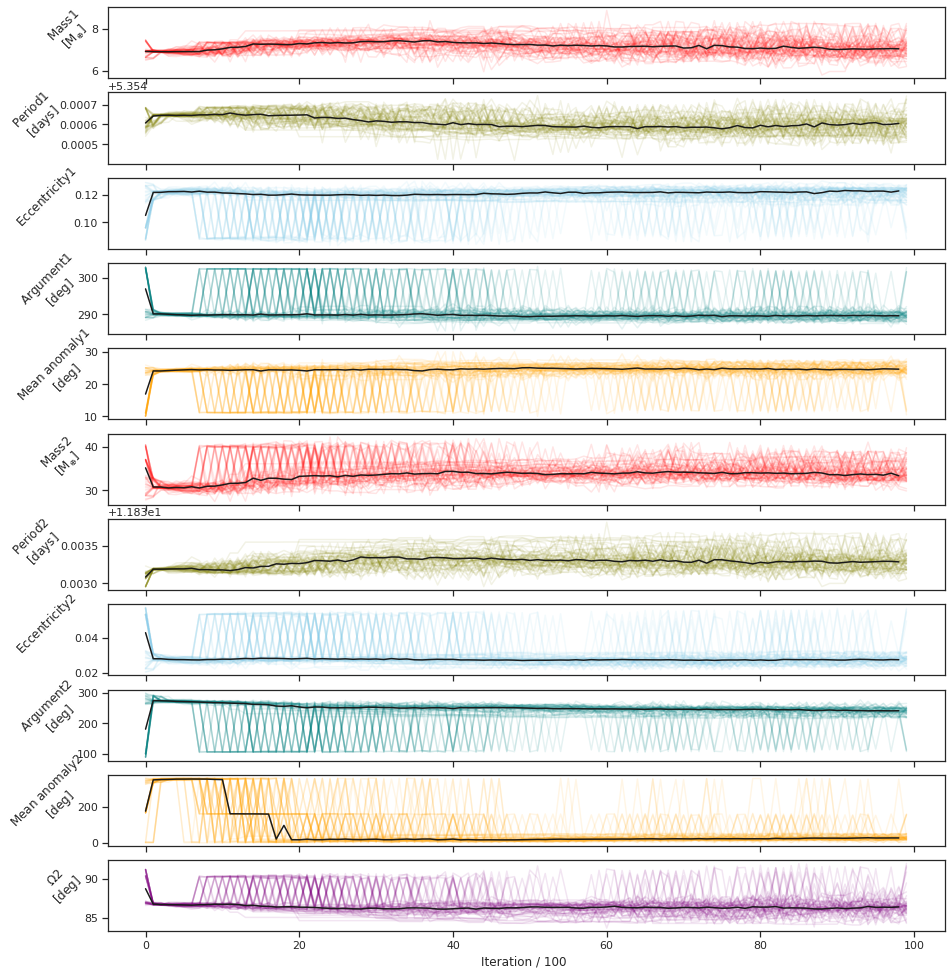

In [42]:
# Plot the mean movement of the chains as black lines
nauplot.trace_plot(size=(15,17),plot_means=True);

**Corner plot**

And now a corner plot to visualize possible correlations between variables

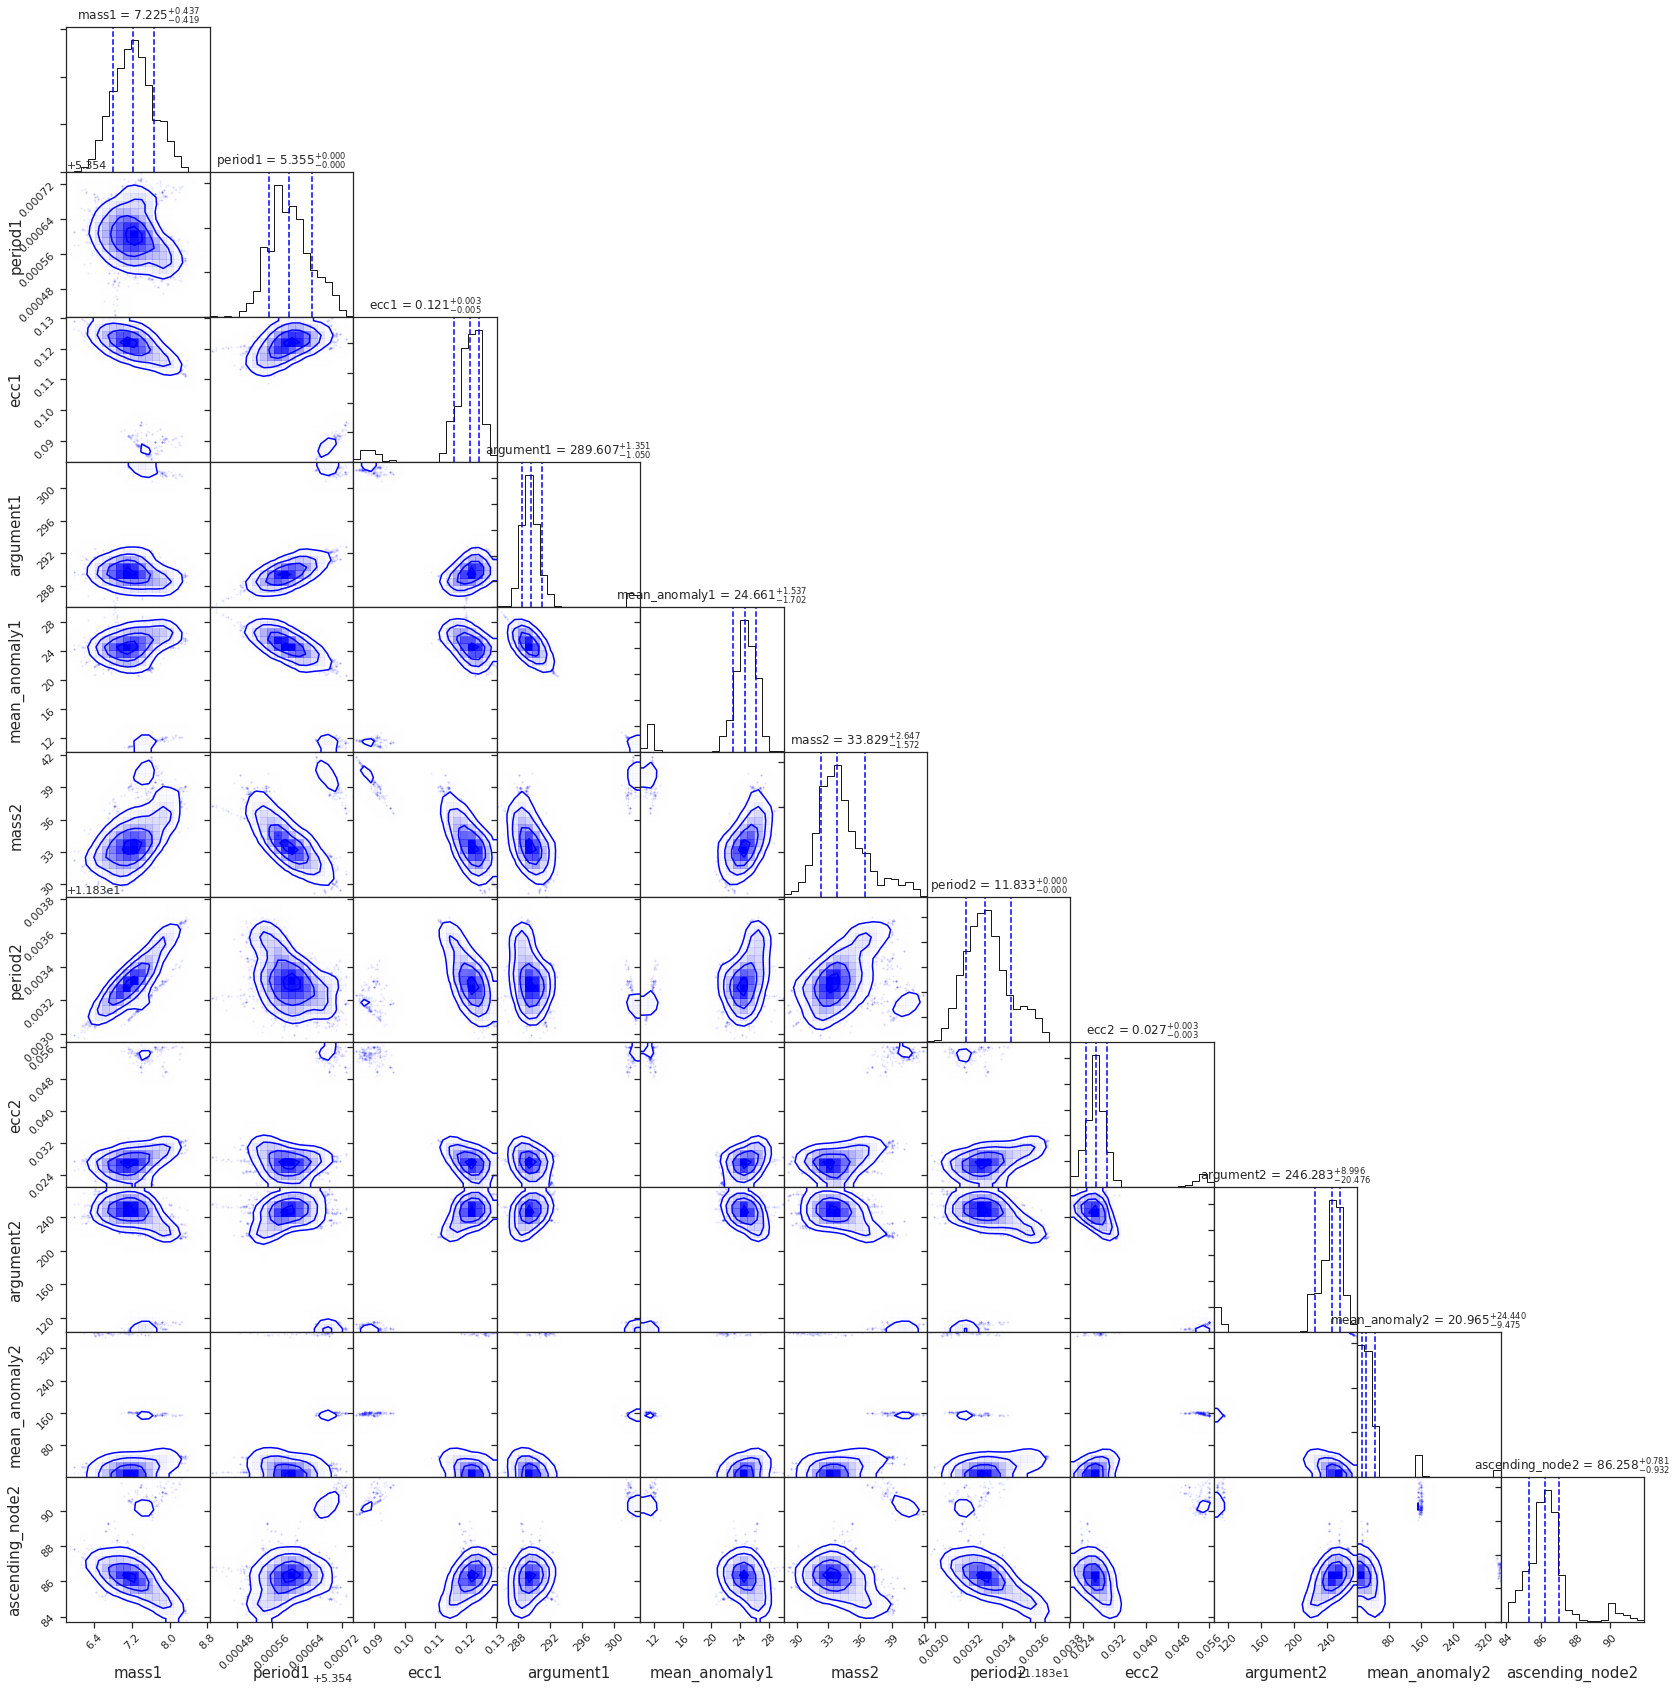

In [43]:
nauplot.corner_plot(color='blue', titles=True);

**TTVs**

In order to visualize the TTVs that the posteriors represent, use the function 'TTVs'. It takes solutions from the MCMC chains to calculate the mid-transit times and the resulting TTVs. Two modes are available: mode 'random' take random samples from the chains; 'best' take the best solutions from the chains until complete -nsols-.

--> plotting random solutions


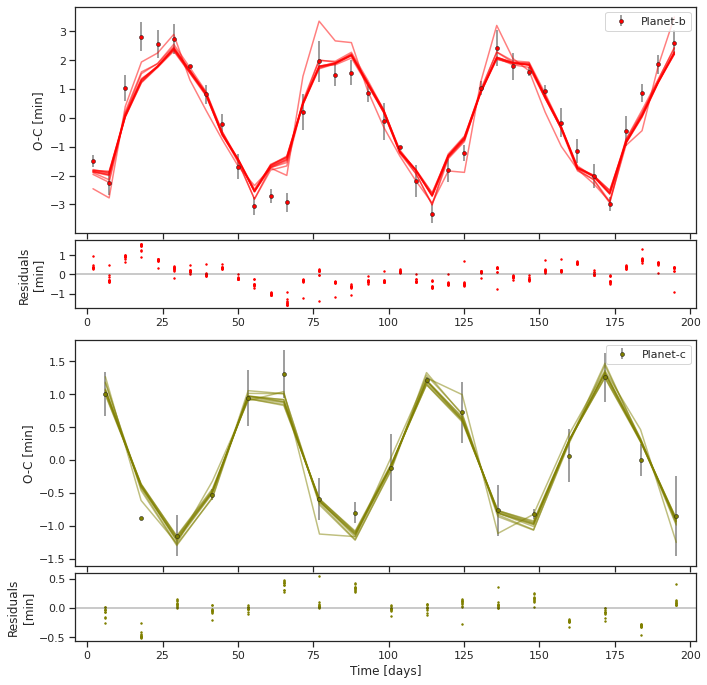

In [44]:
nauplot.TTVs(mode='random',  # Take random samples from the posteriors.
                  nsols=10);       # Number of solutions to draw
plt.savefig('TTVs_mcmc.png')

That's a much better fitting than the done before with the optimizers in the previous tutorial. Compare yourself both images!

**At this point, we have seen how the MCMC module works. We also see the fast way of getting the results and how to visualize them. If you are interested in going further into Nauyaca, see the scripts in the Examples directory.  These include many other features in Nauyaca that can be useful in your research. See you there!**

_______________